In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from AnsatzLacs import *
from PurificationUtil import *
from qiskit_algorithms.optimizers import SPSA
import sys

In [2]:
# implementation of the slack variabel method
# quantum circuit settings
# these values will be used as global variables later in different functions
sys_size = 2 # size of the input state (2 means 2 qubit)
ref_size = 2 # size of the reference state (for purification)

In [3]:
H_paulis = ["ZZ", "IX", "XI"]
coeff = [1, 1, 1]
As = ["YI", "IZ"]
H_unitary = [get_expectation_unitary(h_i) for h_i in H_paulis] 
As_unitary = [get_expectation_unitary(a_i) for a_i in As]
b = [0.2, 0.1]
INF = sys.maxsize

In [4]:
expectation_unitary_dict = {pauli_string: get_expectation_unitary(pauli_string) for pauli_string in H_paulis}
for a_i in As:
    expectation_unitary_dict[a_i] = get_expectation_unitary(a_i)

In [5]:
def get_exp(pauli_string, ansatz, shots):
    return get_exp_helper(expectation_unitary_dict, pauli_string, ansatz, shots)

In [6]:
#CVXpy solutions
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1,0], [0 ,-1]])
Y = np.array([[0, -1j], [1j, 0]])
H = np.kron(Z,Z) + np.kron(np.eye(2), X) + np.kron(X, np.eye(2))
A_2 = np.kron(np.eye(2),Z)
A_1 = np.kron(Y,np.eye(2))
a1 = 0.2
a2 = 0.1
rho = cp.Variable( np.eye(4).shape, hermitian=True)
constraints = [rho >> 0, cp.real(cp.trace(A_1 @ rho)) >= a1,cp.real(cp.trace(A_2 @ rho)) >= a2, cp.trace(rho) ==1]
prob = cp.Problem(cp.Minimize(cp.real(cp.trace(H @ rho))),
                  constraints)
# Solve SDP
prob.solve(verbose=False)
expected = prob.value
print("Aprroximated value:", prob.value)

WARN: A->p (column pointers) not strictly increasing, column 10 empty
WARN: A->p (column pointers) not strictly increasing, column 15 empty
WARN: A->p (column pointers) not strictly increasing, column 20 empty
WARN: A->p (column pointers) not strictly increasing, column 25 empty
Aprroximated value: -2.2096976087674225


In [7]:
def get_gradient(params, fun):
    delta = 1 - 2 * np.random.binomial(1, 0.5, size=len(params))
    plus = fun(params + perturbation*delta)
    minus = fun(params - perturbation*delta)
    grad = (plus-minus)/(2*perturbation*delta)

    norm = np.linalg.norm(grad)
    if norm > 1:
        grad = grad/norm
    
    return grad

def gradient_descent(fun, x0, jac, maxiter, callback = None):
    x = x0
    for i in range(maxiter):
        iteration = i + 1
        
        x -= lr * jac(x, fun)
        
        if callback != None:
            callback(x, iteration)
    return x

# Interior Point Method

In [8]:
def cost_function_full_IP(params):
    """
    params: in the form of [params]
    """
    # Tr[Hρ]
    ansatz.set_params(params)
    obj = 0
    for i in range(len(H_paulis)):
        obj += get_exp(H_paulis[i], ansatz, num_shots)
    
    # Tr[A_iρ] - b_i
    penal = 0
    for i in range(len(As_unitary)):
        constraint = get_exp(As[i], ansatz, num_shots) - b[i]
        if constraint <= 0:
            penal += INF
        else:
            penal += np.log(constraint)
            
    cost = obj - mu * penal
    return cost, obj, penal

def cost_function_IP(params):
    """
    params: in the form of [params]
    """
    cost, _, _ = cost_function_full_IP(params)
    return cost

In [9]:
print_every = 100
def callback_IP(x, iteration):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    global mu
    global prev_params
    global lr
    
    fx, obj, penal = cost_function_full_IP(x)
    IP_loss.append(fx)
    IP_penals.append(penal)
    IP_objectives.append(obj)
        
    # if crossed the boundary, reset the parameters and decrease lr
    if abs(fx - IP_loss[-2]) >= 1e4:
        ansatz.set_params(prev_params)
        x = prev_params
        lr = max(lr / 5, lr_min)
        fx, obj, penal = cost_function_full_IP(x)
        IP_loss[-1] = fx
        IP_penals[-1] = penal
        IP_objectives[-1] = obj

    # change the learning rate dynamically
    if fx > IP_loss[-2]:
        lr = max(lr / 2, lr_max)
    else:
        lr = min(lr * 1.5, lr_min)
    
    if(iteration % print_every == 0):
        print(f"Iteration: {iteration}\tCost: {round(fx,4)}\tPenalty: {round(penal, 4)}\tObj: {round(obj, 4)}\tmu: {mu}\tlr: {round(lr, 4)}")
        mu = max(mu * 0.6, 1e-8)
        
    prev_params = copy.deepcopy(x)

In [10]:
def satisfied(ansatz):
    """
    Initialize ansatz until the constraints are satisfied
    """
    sat = True
    for i in range(len(As_unitary)):
        constraint = get_exp(As[i], ansatz, num_shots) - b[i]
        if constraint < 0:
            sat = False
    return sat

In [11]:
num_shots = 1e12
max_iter = 5 * 1000
lr_max = 1e-1
lr_min = 1e-8
perturbation = 1e-4
IP_num_layers = 1

In [12]:
n = 5
record = 0

costs_IP_outer = []
objs_IP_outer = []
penalties_IP_outer = []

for i in range(n):
    ansatz = create_ansatz("general", sys_size, ref_size, IP_num_layers)

    while not satisfied(ansatz):
        seed = np.random.randint(1e5)
        np.random.seed(seed)
        params = np.random.normal(size=ansatz.get_parameter_num()) % (2 * np.pi)
        ansatz.set_params(params)
        init_seed = seed
        
    mu = 1
    lr = 1e-3
    
    init_params = ansatz.params
    prev_params = copy.deepcopy(init_params)
    
    init_cost, init_obj, init_penal = cost_function_full_IP(init_params)
    IP_loss = [init_cost]
    IP_penals = [init_penal]
    IP_objectives = [init_obj]
    
    print("Expected value:", expected)
    print(f"Inital cost: {round(init_cost, 4)}")
    result = gradient_descent(cost_function_IP, init_params, get_gradient, max_iter, callback=callback_IP)
    
    costs_IP_outer.append(IP_loss)
    objs_IP_outer.append(IP_objectives)
    penalties_IP_outer.append(IP_penals)

    if abs(IP_loss[-1] - expected) <= 0.05:
        dir_name = f"Constrained_Ham_purification_IP/interior_point"
        problem_name = "IP"
        filename = f"Init_{init_seed}"
        save_data_to_file(IP_loss, IP_penals, IP_objectives, problem_name, dir_name, filename)
        record += 1
        
print(f"Number of successful trials: {record}")

Expected value: -2.2096976087674225
Inital cost: 4.1447
Iteration: 100	Cost: 1.4451	Penalty: -1.5687	Obj: -0.1236	mu: 1	lr: 0.0
Iteration: 200	Cost: -0.244	Penalty: -0.9842	Obj: -0.8345	mu: 0.6	lr: 0.0
Iteration: 300	Cost: -0.8707	Penalty: -1.1136	Obj: -1.2716	mu: 0.36	lr: 0.0
Iteration: 400	Cost: -1.3433	Penalty: -1.6409	Obj: -1.6977	mu: 0.216	lr: 0.1
Iteration: 500	Cost: -1.6145	Penalty: -2.2524	Obj: -1.9064	mu: 0.1296	lr: 0.0
Iteration: 600	Cost: -1.7966	Penalty: -2.6654	Obj: -2.0039	mu: 0.07776	lr: 0.1
Iteration: 700	Cost: -1.933	Penalty: -3.5438	Obj: -2.0983	mu: 0.046655999999999996	lr: 0.1
Iteration: 800	Cost: -2.015	Penalty: -4.4965	Obj: -2.1409	mu: 0.027993599999999997	lr: 0.0
Iteration: 900	Cost: -2.0728	Penalty: -5.8817	Obj: -2.1716	mu: 0.016796159999999997	lr: 0.1
Iteration: 1000	Cost: -2.1012	Penalty: -7.306	Obj: -2.1749	mu: 0.010077695999999999	lr: 0.0
Iteration: 1100	Cost: -2.1393	Penalty: -7.3828	Obj: -2.1839	mu: 0.006046617599999999	lr: 0.0
Iteration: 1200	Cost: -2.1571

Iteration: 4200	Cost: -2.1607	Penalty: -6.9075	Obj: -2.1607	mu: 1e-08	lr: 0.1
Iteration: 4300	Cost: -2.1607	Penalty: -6.9076	Obj: -2.1607	mu: 1e-08	lr: 0.0
Iteration: 4400	Cost: -2.1607	Penalty: -6.9076	Obj: -2.1607	mu: 1e-08	lr: 0.0
Iteration: 4500	Cost: -2.1607	Penalty: -6.9075	Obj: -2.1607	mu: 1e-08	lr: 0.0
Iteration: 4600	Cost: -2.1607	Penalty: -6.9075	Obj: -2.1607	mu: 1e-08	lr: 0.1
Iteration: 4700	Cost: -2.1607	Penalty: -6.9076	Obj: -2.1607	mu: 1e-08	lr: 0.1
Iteration: 4800	Cost: -2.1607	Penalty: -6.9075	Obj: -2.1607	mu: 1e-08	lr: 0.1
Iteration: 4900	Cost: -2.1607	Penalty: -6.9075	Obj: -2.1607	mu: 1e-08	lr: 0.1
Iteration: 5000	Cost: -2.1607	Penalty: -6.9076	Obj: -2.1607	mu: 1e-08	lr: 0.0
Data saved to Constrained_Ham_purification_IP/interior_point/Init_18419-IP.pkl successfully!
Expected value: -2.2096976087674225
Inital cost: 1.3173
Iteration: 100	Cost: 0.1004	Penalty: -1.0217	Obj: -0.9214	mu: 1	lr: 0.0
Iteration: 200	Cost: -0.7878	Penalty: -0.9395	Obj: -1.3515	mu: 0.6	lr: 0.1
It

Iteration: 3400	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 4.7751966659678364e-08	lr: 0.0
Iteration: 3500	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 2.8651179995807016e-08	lr: 0.1
Iteration: 3600	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1.7190707997484207e-08	lr: 0.0
Iteration: 3700	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1.0314424798490525e-08	lr: 0.1
Iteration: 3800	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1e-08	lr: 0.1
Iteration: 3900	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1e-08	lr: 0.0
Iteration: 4000	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1e-08	lr: 0.1
Iteration: 4100	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1e-08	lr: 0.1
Iteration: 4200	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1e-08	lr: 0.1
Iteration: 4300	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1e-08	lr: 0.0
Iteration: 4400	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1e-08	lr: 0.0
Iteration: 4500	Cost: -2.1651	Penalty: -5.6997	Obj: -2.1651	mu: 1e-08	lr: 

# QSlack Method

In [13]:
#Problem setup
pauli = ['ZZ','XI','IX','YI','IZ']
H_paulis = ['ZZ','XI','IX']
expectation_unitary_dict = {pauli_string: get_expectation_unitary(pauli_string) for pauli_string in pauli}

a1 = 0.2
a2 = 0.1

In [14]:
def get_trace(ansatz1, ansatz2, shots):
    return get_trace_helper(swap_test_unitary, ansatz1, ansatz2, shots)

def get_exp(pauli_string, ansatz, shots):
    return get_exp_helper(expectation_unitary_dict, pauli_string, ansatz, shots)

In [15]:
# precompute terms
# Tr[H^2]=12, Tr[A1^2]=Tr[A2^2]=4
TrH2 = 12
TrA_12 = 4
TrA_22 = 4

In [16]:
def cost_function_full_QS(params):
    # update parameters
    lmbda = params[-2] ** 2
    mu = params[-1] ** 2
     
    params = params[:primal_num_params]
    omega.set_params(params)
  
    # calculate new cost
    obj = 0
    for i in range(len(H_paulis)):
        obj += get_exp(H_paulis[i], omega, num_shots)

    est2 = get_exp(pauli[3], omega, num_shots)
    est3 = get_exp(pauli[4], omega, num_shots)
    penalty = (lmbda - est2 + a1)**2 + (mu - est3 + a2)**2
    cost = obj + c * penalty
    return cost, obj, penalty

def cost_function_QS(params):
    cost, _, _ = cost_function_full_QS(params)
    return cost

In [17]:
print_every = 100
def callback_QS(nfev, x, fx, stepsize, accepted=False):
    '''
    Callback function called automatically during optimization. 
    Appends loss value, penalties, and objective value.
    Print out the training status throughout the training.
    '''
    global primal_loss
    global primal_penals
    global primal_ojectives
    
    fx, obj, penal = cost_function_full_QS(x)
    primal_loss.append(fx)
    primal_penals.append(penal)
    primal_objectives.append(obj)
        
    if(nfev % print_every == 0):
        print(f"Iteration: {nfev//3}\tCost: {round(fx,4)}\tObj: {round(obj, 4)}\tPenalty: {round(penal, 4)}\tc: {c}")

In [18]:
num_shots = 1e12
max_iter = 20 * 1000

lr_max = 1e-1
lr_min = 1e-3
dec_interval = 1000
train_lr = get_lr(lr_max, lr_min, dec_interval, max_iter) # halve the lr every 1000 iterations

pertb = 1e-4
trust = True

primal_num_layers = 2
primal_num_params = get_parameter_number("general", sys_size, ref_size, primal_num_layers)

In [19]:
num_runs = 5
record = 0 # record the number of successful trails

costs_primal_outer = []
objs_primal_outer = []
penalties_primal_outer = []

for i in range(num_runs):
    np.random.seed(i)
    lmbda = 0.1
    mu = 0.5
    c = 100

    lr = lr_max
    
    primal_loss = []
    primal_penals = []
    primal_objectives = []

    print(f"Exact value: {expected}")
    omega = create_ansatz("general", sys_size, ref_size, primal_num_layers)
    init_params = [*omega.params, np.sqrt(lmbda), np.sqrt(mu)]
    print(f"Iteration {i}, Initial cost : {cost_function_QS(init_params)}")
    
    autospsa = SPSA(maxiter=max_iter, learning_rate=train_lr,
                        perturbation=pertb, callback=callback_QS, trust_region=trust)
    obj = autospsa.minimize(fun=cost_function_QS, x0=init_params)
    
    costs_primal_outer.append(primal_loss)
    objs_primal_outer.append(primal_objectives)
    penalties_primal_outer.append(primal_penals)

    if abs(primal_loss[-1] - expected) <= 0.05:
        dir_name = f"Constrained_Ham_purification_IP/QSlack"
        problem_name = "QS"
        filename = f"Init_{i}"
        save_data_to_file(primal_loss, primal_penals, primal_objectives, problem_name, dir_name, filename)
        record += 1
print(f"Number of successful runs: {record}")


Exact value: -2.2096976087674225
Iteration 0, Initial cost : 61.39406820843507
Iteration: 100	Cost: -0.2178	Obj: -0.3452	Penalty: 0.0013	c: 100
Iteration: 200	Cost: -0.6605	Obj: -0.7485	Penalty: 0.0009	c: 100
Iteration: 300	Cost: -1.0518	Obj: -1.1048	Penalty: 0.0005	c: 100
Iteration: 400	Cost: -1.2122	Obj: -1.2201	Penalty: 0.0001	c: 100
Iteration: 500	Cost: -1.4077	Obj: -1.4162	Penalty: 0.0001	c: 100
Iteration: 600	Cost: -1.4793	Obj: -1.5292	Penalty: 0.0005	c: 100
Iteration: 700	Cost: -1.4257	Obj: -1.6072	Penalty: 0.0018	c: 100
Iteration: 800	Cost: -1.2534	Obj: -1.4105	Penalty: 0.0016	c: 100
Iteration: 900	Cost: -1.3853	Obj: -1.4549	Penalty: 0.0007	c: 100
Iteration: 1000	Cost: -1.3179	Obj: -1.4107	Penalty: 0.0009	c: 100
Iteration: 1100	Cost: -1.6303	Obj: -1.6526	Penalty: 0.0002	c: 100
Iteration: 1200	Cost: -1.7522	Obj: -1.7813	Penalty: 0.0003	c: 100
Iteration: 1300	Cost: -1.6891	Obj: -1.7424	Penalty: 0.0005	c: 100
Iteration: 1400	Cost: -1.7932	Obj: -1.7955	Penalty: 0.0	c: 100
Iteration

Iteration: 12900	Cost: -2.2093	Obj: -2.2094	Penalty: 0.0	c: 100
Iteration: 13000	Cost: -2.2093	Obj: -2.2094	Penalty: 0.0	c: 100
Iteration: 13100	Cost: -2.2093	Obj: -2.2094	Penalty: 0.0	c: 100
Iteration: 13200	Cost: -2.2093	Obj: -2.2094	Penalty: 0.0	c: 100
Iteration: 13300	Cost: -2.2093	Obj: -2.2094	Penalty: 0.0	c: 100
Iteration: 13400	Cost: -2.2093	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 13500	Cost: -2.2093	Obj: -2.2094	Penalty: 0.0	c: 100
Iteration: 13600	Cost: -2.2093	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 13700	Cost: -2.2093	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 13800	Cost: -2.2093	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 13900	Cost: -2.2093	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 14000	Cost: -2.2093	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 14100	Cost: -2.2093	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 14200	Cost: -2.2093	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 14300	Cost: -2.2094	Obj: -2.2095	Penalty: 0.0	c: 100
Iteration: 14400	Cost: -2.2094	Obj: -2.2

Iteration: 5500	Cost: -2.2022	Obj: -2.2022	Penalty: 0.0	c: 100
Iteration: 5600	Cost: -2.2025	Obj: -2.2028	Penalty: 0.0	c: 100
Iteration: 5700	Cost: -2.203	Obj: -2.2032	Penalty: 0.0	c: 100
Iteration: 5800	Cost: -2.2033	Obj: -2.2037	Penalty: 0.0	c: 100
Iteration: 5900	Cost: -2.2034	Obj: -2.2035	Penalty: 0.0	c: 100
Iteration: 6000	Cost: -2.2036	Obj: -2.204	Penalty: 0.0	c: 100
Iteration: 6100	Cost: -2.2039	Obj: -2.204	Penalty: 0.0	c: 100
Iteration: 6200	Cost: -2.204	Obj: -2.2042	Penalty: 0.0	c: 100
Iteration: 6300	Cost: -2.2042	Obj: -2.2044	Penalty: 0.0	c: 100
Iteration: 6400	Cost: -2.2043	Obj: -2.2045	Penalty: 0.0	c: 100
Iteration: 6500	Cost: -2.2045	Obj: -2.2047	Penalty: 0.0	c: 100
Iteration: 6600	Cost: -2.2047	Obj: -2.2049	Penalty: 0.0	c: 100
Iteration: 6700	Cost: -2.2049	Obj: -2.2051	Penalty: 0.0	c: 100
Iteration: 6800	Cost: -2.205	Obj: -2.2051	Penalty: 0.0	c: 100
Iteration: 6900	Cost: -2.2051	Obj: -2.2053	Penalty: 0.0	c: 100
Iteration: 7000	Cost: -2.2053	Obj: -2.2055	Penalty: 0.0	c: 1

Iteration: 18500	Cost: -2.2086	Obj: -2.2087	Penalty: 0.0	c: 100
Iteration: 18600	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 18700	Cost: -2.2086	Obj: -2.2087	Penalty: 0.0	c: 100
Iteration: 18800	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 18900	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19000	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19100	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19200	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19300	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19400	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19500	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19600	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19700	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19800	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 19900	Cost: -2.2087	Obj: -2.2089	Penalty: 0.0	c: 100
Iteration: 20000	Cost: -2.2087	Obj: -2.2

Iteration: 11200	Cost: -2.2042	Obj: -2.2043	Penalty: 0.0	c: 100
Iteration: 11300	Cost: -2.2042	Obj: -2.2043	Penalty: 0.0	c: 100
Iteration: 11400	Cost: -2.2043	Obj: -2.2044	Penalty: 0.0	c: 100
Iteration: 11500	Cost: -2.2043	Obj: -2.2044	Penalty: 0.0	c: 100
Iteration: 11600	Cost: -2.2043	Obj: -2.2044	Penalty: 0.0	c: 100
Iteration: 11700	Cost: -2.2044	Obj: -2.2045	Penalty: 0.0	c: 100
Iteration: 11800	Cost: -2.2044	Obj: -2.2046	Penalty: 0.0	c: 100
Iteration: 11900	Cost: -2.2045	Obj: -2.2046	Penalty: 0.0	c: 100
Iteration: 12000	Cost: -2.2046	Obj: -2.2047	Penalty: 0.0	c: 100
Iteration: 12100	Cost: -2.2046	Obj: -2.2047	Penalty: 0.0	c: 100
Iteration: 12200	Cost: -2.2047	Obj: -2.2048	Penalty: 0.0	c: 100
Iteration: 12300	Cost: -2.2047	Obj: -2.2049	Penalty: 0.0	c: 100
Iteration: 12400	Cost: -2.2047	Obj: -2.205	Penalty: 0.0	c: 100
Iteration: 12500	Cost: -2.2048	Obj: -2.2049	Penalty: 0.0	c: 100
Iteration: 12600	Cost: -2.2048	Obj: -2.205	Penalty: 0.0	c: 100
Iteration: 12700	Cost: -2.2049	Obj: -2.205

Iteration: 3800	Cost: -2.1867	Obj: -2.1872	Penalty: 0.0	c: 100
Iteration: 3900	Cost: -2.1891	Obj: -2.1922	Penalty: 0.0	c: 100
Iteration: 4000	Cost: -2.1917	Obj: -2.1975	Penalty: 0.0001	c: 100
Iteration: 4100	Cost: -2.1974	Obj: -2.1977	Penalty: 0.0	c: 100
Iteration: 4200	Cost: -2.1996	Obj: -2.1997	Penalty: 0.0	c: 100
Iteration: 4300	Cost: -2.2007	Obj: -2.2011	Penalty: 0.0	c: 100
Iteration: 4400	Cost: -2.2014	Obj: -2.2015	Penalty: 0.0	c: 100
Iteration: 4500	Cost: -2.2014	Obj: -2.2027	Penalty: 0.0	c: 100
Iteration: 4600	Cost: -2.202	Obj: -2.202	Penalty: 0.0	c: 100
Iteration: 4700	Cost: -2.2019	Obj: -2.2021	Penalty: 0.0	c: 100
Iteration: 4800	Cost: -2.2017	Obj: -2.2017	Penalty: 0.0	c: 100
Iteration: 4900	Cost: -2.2013	Obj: -2.2019	Penalty: 0.0	c: 100
Iteration: 5000	Cost: -2.2028	Obj: -2.2029	Penalty: 0.0	c: 100
Iteration: 5100	Cost: -2.2034	Obj: -2.2035	Penalty: 0.0	c: 100
Iteration: 5200	Cost: -2.2034	Obj: -2.2038	Penalty: 0.0	c: 100
Iteration: 5300	Cost: -2.2037	Obj: -2.2037	Penalty: 0.

Iteration: 16800	Cost: -2.2086	Obj: -2.2087	Penalty: 0.0	c: 100
Iteration: 16900	Cost: -2.2086	Obj: -2.2087	Penalty: 0.0	c: 100
Iteration: 17000	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17100	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17200	Cost: -2.2086	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17300	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17400	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17500	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17600	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17700	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17800	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 17900	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 18000	Cost: -2.2087	Obj: -2.2088	Penalty: 0.0	c: 100
Iteration: 18100	Cost: -2.2087	Obj: -2.2089	Penalty: 0.0	c: 100
Iteration: 18200	Cost: -2.2087	Obj: -2.2089	Penalty: 0.0	c: 100
Iteration: 18300	Cost: -2.2087	Obj: -2.2

Iteration: 9500	Cost: -2.2038	Obj: -2.2039	Penalty: 0.0	c: 100
Iteration: 9600	Cost: -2.2039	Obj: -2.204	Penalty: 0.0	c: 100
Iteration: 9700	Cost: -2.204	Obj: -2.2041	Penalty: 0.0	c: 100
Iteration: 9800	Cost: -2.2041	Obj: -2.2043	Penalty: 0.0	c: 100
Iteration: 9900	Cost: -2.2042	Obj: -2.2043	Penalty: 0.0	c: 100
Iteration: 10000	Cost: -2.2042	Obj: -2.2044	Penalty: 0.0	c: 100
Iteration: 10100	Cost: -2.2043	Obj: -2.2045	Penalty: 0.0	c: 100
Iteration: 10200	Cost: -2.2044	Obj: -2.2045	Penalty: 0.0	c: 100
Iteration: 10300	Cost: -2.2045	Obj: -2.2046	Penalty: 0.0	c: 100
Iteration: 10400	Cost: -2.2045	Obj: -2.2047	Penalty: 0.0	c: 100
Iteration: 10500	Cost: -2.2046	Obj: -2.2047	Penalty: 0.0	c: 100
Iteration: 10600	Cost: -2.2047	Obj: -2.2048	Penalty: 0.0	c: 100
Iteration: 10700	Cost: -2.2047	Obj: -2.2049	Penalty: 0.0	c: 100
Iteration: 10800	Cost: -2.2048	Obj: -2.2049	Penalty: 0.0	c: 100
Iteration: 10900	Cost: -2.2049	Obj: -2.205	Penalty: 0.0	c: 100
Iteration: 11000	Cost: -2.205	Obj: -2.2051	Penal

# Plots

In [20]:
# plt.rc('font', family='Times New Roman')
plt.rc('font', family='Arial')
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('legend', framealpha = 1)
plt.rc('legend', shadow = True)

In [21]:
# Size of the smoothing window
window_size_primal = 100
window_size_dual = 100

costs_primal_smooth = get_smooth(costs_primal_outer[:-1], window_size_primal)
costs_IP_smooth = get_smooth(costs_IP_outer[:-1], window_size_dual)

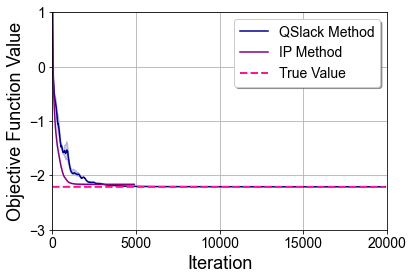

In [22]:
# IQR plot
costs_primal_median = np.median(costs_primal_smooth, axis = 0)
costs_primal_max = np.percentile(costs_primal_smooth, 75, axis = 0)
costs_primal_min = np.percentile(costs_primal_smooth, 25, axis = 0)

costs_IP_median = np.median(costs_IP_smooth, axis = 0)
costs_IP_max = np.percentile(costs_IP_smooth, 75, axis = 0)
costs_IP_min = np.percentile(costs_IP_smooth, 25, axis = 0)

# Plotting the line graph
x1 = len(costs_primal_median)
x2 = len(costs_IP_median)
x3 = max(x1, x2)
expected_line = np.zeros(x3) + expected
plt.plot(np.arange(x1), costs_primal_median, color = 'darkblue', linewidth = 1.5)
plt.plot(np.arange(x2), costs_IP_median, color = 'purple', linewidth = 1.5)
plt.plot(np.arange(x3), expected_line, linestyle='dashed', color = 'deeppink', markersize = 1, linewidth = 2)

plt.legend(['QSlack Method','IP Method', 'True Value'])

plt.fill_between(np.arange(x1), costs_primal_max, costs_primal_min, color = 'darkblue', alpha = .2)
plt.fill_between(np.arange(x2), costs_IP_max, costs_IP_min, color = 'plum', alpha = .2)

plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.ylim(-3, 1)
plt.xlim(0, max_iter)
# plt.yscale("log")

# Display the graph
plt.show()